In [2]:
import torch
from torchvision.models.video.resnet import model_urls

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")

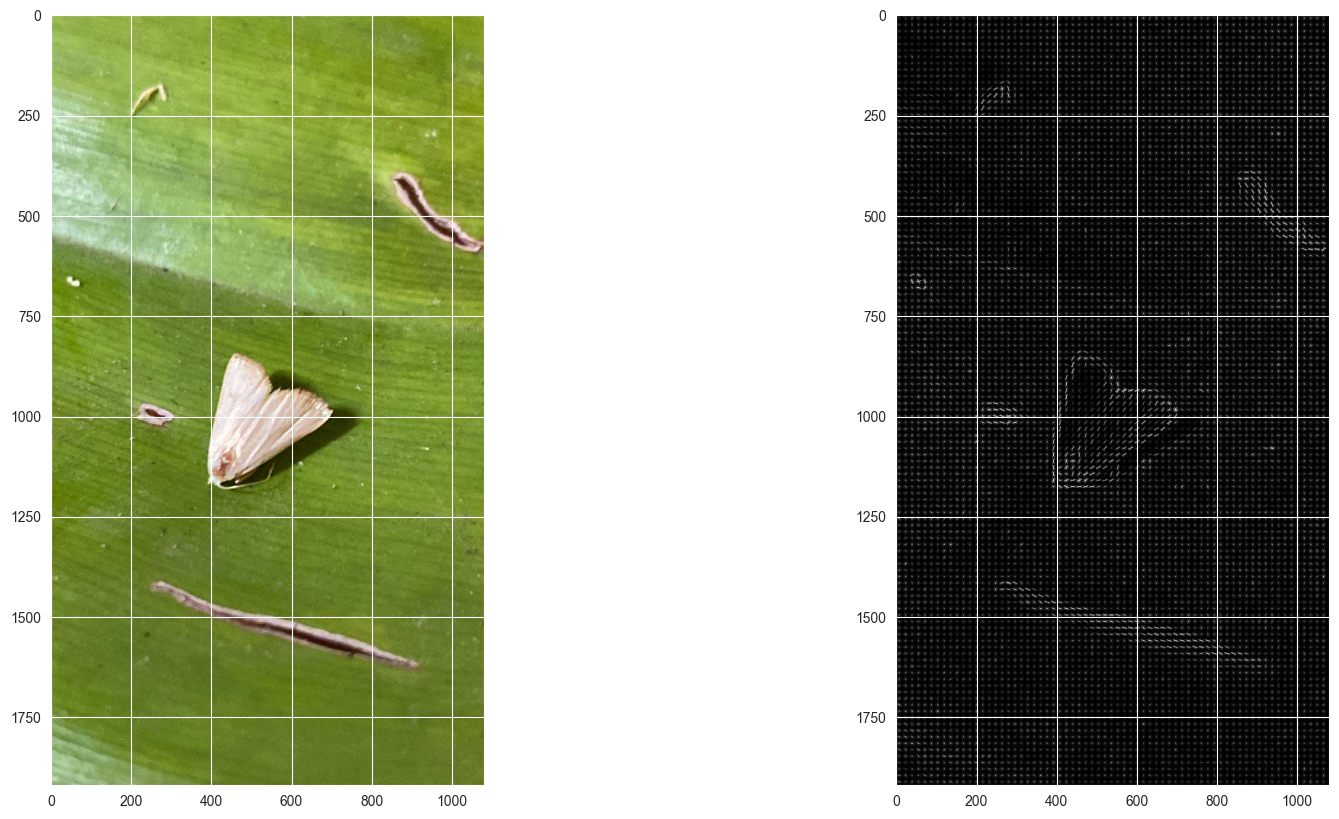

In [4]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data,  exposure

image_path = 'unrelated_data/8a10f0e3-e55b-4517-9fb2-7ad25a8fe3d3.jpg'

im = plt.imread(image_path)

fg, hog_img = hog(im,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,)

hog_rescaled = exposure.rescale_intensity(hog_img, in_range=(0,10))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(im, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(hog_rescaled, cmap='gray')

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets

# --- Data Augmentation Pipelines ---
training_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.RandomCrop(height=180, width=180, p=0.7),
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.4),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.3),
    A.ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.4, 0.8), hue=(-0.1, 0.1), p=0.3),
    A.OneOf([
        A.GaussNoise(std_range=(0.01, 0.1), per_channel=True, p=0.3),
        A.CoarseDropout(num_holes_range=(1, 2), hole_height_range=(0.1, 0.2), hole_width_range=(0.1, 0.2), fill=0, p=0.3)
    ], p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

bw_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.ToGray(p=1.0),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


# Custom dataset class to apply Albumentations transforms
class AlbumentationsImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = np.array(Image.open(path).convert("RGB"))
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, target


In [5]:
from torch import nn
from torchvision import  models

class PestClassifierResNet50(nn.Module):

    def __init__(self, num_classes):

        super(PestClassifierResNet50,self).__init__()

        self.base_model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.fc.in_features

        self.base_model.fc = nn.Sequential(
            nn.Dropout(p=0.4, inplace=False),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        return self.base_model(x)

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= 4):
            print('\nLayer out of range. ')

        layer_name = f'layer{layer}'

        layer_to_unfreeze = getattr(self.base_model, layer_name)

        for params in layer_to_unfreeze.parameters():

            params.requires_grad = True


In [88]:
class PestClassifierEfficientNetV2M(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierEfficientNetV2M, self).__init__()

        self.base_model = models.efficientnet_v2_m(weights='EfficientNet_V2_M_Weights.IMAGENET1K_V1')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=False),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        features = self.base_model.features(x)

        features = self.base_model.avgpool(features)

        features = torch.flatten(features, start_dim=1)

        features = self.base_model.classifier(features)

        return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        print(f"\nUnfreezing feature layer at index: -{layer}")

        for params in self.base_model.features[-layer].parameters():
            params.requires_grad = True


In [91]:
from tqdm import tqdm

def get_resnet_predictions(model, loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="ResNet Predictions"):
            images = images.to(device)
            outputs = model(images)
            preds.append(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
    return np.concatenate(preds, axis=0)

In [59]:
def get_hog_features(image_paths, image_size=(224, 224)):

    hog_features = []

    for i, path in enumerate(image_paths):

        img = imread(path, as_gray=True)

        resized_img = resize(img, image_size, anti_aliasing=True)

        features = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(features)

    return np.array(hog_features)

In [8]:
def KNN_predict(model, path):

    # Assume this is the path to your new image

    # Preprocessing and HOG feature extraction
    new_img = imread(new_image_path, as_gray=True)
    resized_new_img = resize(new_img, (224, 224))
    new_features = hog(resized_new_img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

    # Reshape the single feature vector for prediction
    new_features = new_features.reshape(1, -1)

    probabilities = model.predict_proba(new_features)[0]

    # The predicted class is the one with the highest probability
    predicted_class_label = np.argmax(probabilities)
    confidence_score = probabilities[predicted_class_label]

    return predicted_class_label, confidence_score


In [18]:
from sklearn.metrics import accuracy_score

def evaluate_knn_model(model, data_dir, image_size=(224, 224)):

    """
    Evaluates a trained KNN model on a test dataset.

    Args:
        model (sklearn.pipeline.Pipeline): The trained KNN model pipeline.
        data_dir (str): The root directory of the test dataset.
        image_size (tuple): The size to resize images to before HOG extraction.

    Returns:
        float: The accuracy of the model on the test dataset.
    """

    print(f"Starting evaluation on the test set at {data_dir}...")

    # Load the test dataset
    test_dataset = datasets.ImageFolder(root=data_dir)
    test_image_paths = [sample[0] for sample in test_dataset.samples]
    test_labels = np.array([sample[1] for sample in test_dataset.samples])

    # Extract HOG features for the entire test set
    test_hog_features = []
    for i, path in enumerate(test_image_paths):
        try:
            img = imread(path, as_gray=True)
            resized_img = resize(img, image_size, anti_aliasing=True)
            features = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
            test_hog_features.append(features)
        except Exception as e:
            print(f"Error processing test image {path}: {e}")
            continue

    test_hog_features = np.array(test_hog_features)

    # Use the trained model to predict on the test features
    test_predictions = model.predict(test_hog_features)

    # Calculate and return the accuracy
    accuracy = accuracy_score(test_labels, test_predictions)
    print("Evaluation complete.")
    return accuracy

In [16]:
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize
from torchvision import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import joblib
import numpy as np

def train_knn_model(data_dir, train_indices, image_size=(224, 224)):
    """
    Extracts HOG features from a dataset and trains a KNN classifier.

    Args:
        data_dir (str): The root directory of the dataset (e.g., 'datasets/train').
        train_indices (list): The indices for the training data split.
        n_neighbors (int): The number of neighbors for the KNN classifier.
        image_size (tuple): The size to resize images to before HOG extraction.

    Returns:
        sklearn.pipeline.Pipeline: A trained KNN model pipeline.
    """
    print("Starting HOG feature extraction for KNN training...")

    # Load the dataset to get image paths and labels
    # We use a simple ImageFolder without transforms to get the file paths

    full_dataset = datasets.ImageFolder(root=data_dir)
    full_image_paths = [sample[0] for sample in full_dataset.samples]
    full_labels = [sample[1] for sample in full_dataset.samples]

    # Get the training data paths and labels based on the provided indices
    train_paths = [full_image_paths[i] for i in train_indices]
    train_labels = [full_labels[i] for i in train_indices]

    hog_features = []
    for i, path in enumerate(train_paths):
        # Read the image and convert to grayscale
        img = imread(path, as_gray=True)
        # Resize to a consistent size
        resized_img = resize(img, image_size)

        # Extract HOG features
        features = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(features)

        if (i + 1) % 100 == 0:
            print(f"  Processed {i+1} images.")

    print("HOG feature extraction complete.")
    hog_features = np.array(hog_features)
    train_labels = np.array(train_labels)

    # We use a pipeline to combine the scaler and the KNN classifier
    knn_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    param_grid = {
        'knn__n_neighbors': [1,3,5,7,9,11,13,15,17,19],
    }

    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(knn_pipeline, param_grid, cv=stratified_kfold, verbose=1)
    grid_search.fit(hog_features, train_labels)

    print("\nHyperparameter tuning complete.")
    print(f"Best n_neighbors: {grid_search.best_params_['knn__n_neighbors']}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

if __name__ == '__main__':

    data_dir = 'datasets/train'
    full_dataset = datasets.ImageFolder(root=data_dir)
    class_names = full_dataset.classes

    # Create an index-based split
    all_indices = list(range(len(full_dataset)))

    # Train the KNN model using your dataset
    trained_knn = train_knn_model(data_dir, all_indices)

    joblib.dump(trained_knn, 'Knn_expreiment/resnet50_KNN_v2.joblib')

    print("\nModel trained successfully!")


Starting HOG feature extraction for KNN training...
  Processed 100 images.
  Processed 200 images.
  Processed 300 images.
  Processed 400 images.
  Processed 500 images.
  Processed 600 images.
  Processed 700 images.
  Processed 800 images.
  Processed 900 images.
  Processed 1000 images.
  Processed 1100 images.
  Processed 1200 images.
  Processed 1300 images.
  Processed 1400 images.
  Processed 1500 images.
  Processed 1600 images.
  Processed 1700 images.
  Processed 1800 images.
  Processed 1900 images.
  Processed 2000 images.
  Processed 2100 images.
  Processed 2200 images.
  Processed 2300 images.
  Processed 2400 images.
  Processed 2500 images.
  Processed 2600 images.
  Processed 2700 images.
  Processed 2800 images.
  Processed 2900 images.
  Processed 3000 images.
  Processed 3100 images.
  Processed 3200 images.
  Processed 3300 images.
  Processed 3400 images.
  Processed 3500 images.
  Processed 3600 images.
  Processed 3700 images.
  Processed 3800 images.
  Proce

In [15]:
data_dir = 'datasets/val'
full_dataset = datasets.ImageFolder(root=data_dir)
class_names = full_dataset.classes
lables = full_dataset.targets

print(class_names)

['brown-planthopper', 'green-leafhopper', 'rice-black-bug', 'rice-leaf-folder', 'stem-borer', 'whorl-maggot']


<h2> Predict using KNN </h2>

In [41]:

knn_inference = joblib.load('Knn_expreiment/hybrid_pest_classification.joblib')

new_image_path = 'datasets/test/brown-planthopper/7 (153).jpg'

unrelated_data = 'unrelated_data/03e42685-76b6-4630-8c64-654925328f77.jpg'

label, confidence = KNN_predict(knn_inference, unrelated_data)

print(f"The predicted class is: {class_names[label]}")
print(f"The confidence score is: {confidence}")


The predicted class is: brown-planthopper
The confidence score is: 0.8


<h2> Testing Results KNN </h2>

In [72]:
inference = joblib.load('Knn_expreiment/resnet50_KNN_v2.joblib')

data_dir = 'datasets/val'

res = evaluate_knn_model(inference, data_dir)

print(f'Testing score: {res:.4f}')


Starting evaluation on the test set at datasets/val...
Evaluation complete.
Testing score: 0.7526


In [83]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_meta_learner(meta_learner, X_test_meta, y_test, class_names):
    """
    Evaluates the trained meta-learner on the test data and prints a classification report.
    """
    final_preds = meta_learner.predict(X_test_meta)
    final_accuracy = accuracy_score(y_test, final_preds)

    print("\n--- Final Classification Report ---")
    print(classification_report(y_test, final_preds, target_names=class_names))

    # Calculate and print the confusion matrix
    final_cm = confusion_matrix(y_test, final_preds)

    cm_df = pd.DataFrame(final_cm, index=class_names, columns=class_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix (standard)')
    plt.ylabel('Actual pests')
    plt.xlabel('Predicted pests')
    plt.show()

    print(f"\nFinal Stacking Ensemble Accuracy: {final_accuracy:.4f}")

In [73]:
# stacking_ensemble.py

import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import joblib

# --- Main Stacking Ensemble Pipeline ---

if __name__ == '__main__':

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    data_dir = 'datasets/train'
    val_dir = 'datasets/val'
    try:
        full_dataset = AlbumentationsImageFolder(root=data_dir, transform=validation_pipeline)
        num_classes = len(full_dataset.classes)

        full_image_paths = [sample[0] for sample in full_dataset.samples]
        full_labels = np.array([sample[1] for sample in full_dataset.samples])

        full_train_index = list(range(len(full_dataset)))

        # --- Load Pre-trained Base Models ---
        print("Loading pre-trained ResNet-50 and KNN models...")

        resnet_model = PestClassifierResNet50(num_classes=num_classes)
        state_dict = torch.load('new_models/Resnet50/SResNet50_rice_pest_classificationV3.pt', map_location=device)
        resnet_model.load_state_dict(state_dict)
        resnet_model.to(device)

        knn_pipeline = joblib.load('Knn_expreiment/resnet50_KNN_v2.joblib')

        # --- Prepare data for Stacking ---
        print("\nPreparing data for Stacking Ensemble...")

        all_resnet_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
        resnet_preds = get_resnet_predictions(resnet_model, all_resnet_loader, device)

        hog_features = get_hog_features(full_image_paths)
        knn_preds = knn_pipeline.predict_proba(hog_features)

        X_meta = np.concatenate((resnet_preds, knn_preds), axis=1)

        X_meta_train = X_meta[full_train_index]
        y_meta_train = full_labels[full_train_index]

        print("\nTraining the final meta-learner...")
        meta_learner = LogisticRegression(solver='lbfgs', max_iter=1000)
        meta_learner.fit(X_meta_train, y_meta_train)

        print("Stacking Ensemble training complete.")
        # --- Evaluation on Val Set ---
        print("\n--- Evaluating the meta-learner on the test set ---")

        # Load the test dataset
        val_dataset = AlbumentationsImageFolder(root=val_dir, transform=validation_pipeline)
        test_image_paths = [sample[0] for sample in val_dataset.samples]
        y_true = np.array([sample[1] for sample in val_dataset.samples])

        # Get predictions for the test set
        val_resnet_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
        val_resnet_preds = get_resnet_predictions(resnet_model, val_resnet_loader, device)
        val_hog_features = get_hog_features(test_image_paths)
        val_knn_preds = knn_pipeline.predict_proba(val_hog_features)

        X_val_meta = np.concatenate((val_resnet_preds, val_knn_preds), axis=1)

        # Evaluate the meta-learner
        class_names = full_dataset.classes
        evaluate_meta_learner(meta_learner, X_val_meta, y_true, class_names)

        joblib.dump(meta_learner, 'stacking_result/meta_learnerV3.joblib')

        print('Meta-learner complete saved!')

    except FileNotFoundError as e:
        print(f"Error: A required file or directory was not found: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Using device: cuda
Loading pre-trained ResNet-50 and KNN models...

Preparing data for Stacking Ensemble...

Training the final meta-learner...
Stacking Ensemble training complete.

--- Evaluating the meta-learner on the test set ---

--- Final Classification Report ---
                   precision    recall  f1-score   support

brown-planthopper       0.80      0.62      0.70       581
 green-leafhopper       0.74      0.74      0.74       893
   rice-black-bug       1.00      0.40      0.57        30
 rice-leaf-folder       0.77      0.84      0.81       548
       stem-borer       0.66      0.82      0.73       404
     whorl-maggot       0.83      0.83      0.83       248

         accuracy                           0.75      2704
        macro avg       0.80      0.71      0.73      2704
     weighted avg       0.76      0.75      0.75      2704

Final Stacking Ensemble Accuracy: 0.7526
Meta-learner complete saved!


In [74]:
def predict_meta_learner(meta_learner, resnet_model, knn_pipeline, image_path, class_names, device):
    """
    Predicts a single image using the stacking ensemble.

    Args:
        meta_learner: The final LogisticRegression meta-model.
        resnet_model: The trained PyTorch ResNet-50 model.
        knn_pipeline: The trained scikit-learn KNN pipeline.
        image_path: The path to the new image to predict.
        class_names: The list of class names.
        device: The device to run the models on.

    Returns:
        tuple: (predicted_class_name, confidence_score)
    """
    try:
        # --- Get ResNet prediction ---
        resnet_image = np.array(Image.open(image_path).convert("RGB"))
        resnet_tensor = validation_pipeline(image=resnet_image)["image"].unsqueeze(0)

        resnet_model.eval()
        with torch.no_grad():
            resnet_output = resnet_model(resnet_tensor)
            resnet_preds = torch.nn.functional.softmax(resnet_output, dim=1).cpu().numpy()

        # --- Get KNN prediction ---
        hog_image = imread(image_path, as_gray=True)
        resized_hog_image = resize(hog_image, (224, 224), anti_aliasing=True)
        hog_features = hog(resized_hog_image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features = hog_features.reshape(1, -1)

        knn_preds = knn_pipeline.predict_proba(hog_features)

        # --- Combine predictions and get final output ---
        meta_features = np.concatenate((resnet_preds, knn_preds), axis=1)
        final_probabilities = meta_learner.predict_proba(meta_features)[0]

        predicted_label = np.argmax(final_probabilities)
        confidence_score = final_probabilities[predicted_label]
        predicted_class_name = class_names[predicted_label]

        return predicted_class_name, confidence_score

    except FileNotFoundError:
        print(f"Error: The file at {image_path} was not found.")
        return None, None
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None, None

<h2> Predict meta learner </h2>

In [35]:
data_dir = 'datasets/val'
full_dataset = datasets.ImageFolder(root=data_dir)
class_names = full_dataset.classes
lables = full_dataset.targets

print(class_names)

['brown-planthopper', 'green-leafhopper', 'rice-black-bug', 'rice-leaf-folder', 'stem-borer', 'whorl-maggot']


In [76]:
hardware = torch.device("cuda" if torch.cuda.is_available() else "cpu")

knn_loader = joblib.load('Knn_expreiment/resnet50_KNN_v2.joblib')

resnet_loader = PestClassifierResNet50(num_classes=6)
resnet_loader.load_state_dict(torch.load('new_models/Resnet50/SResNet50_rice_pest_classificationV3.pt', map_location=hardware))

meta_learner_loader = joblib.load('stacking_result/meta_learnerV3.joblib')

image_path = 'datasets/test/green-leafhopper/GREEN-LEAFHOPPERS_original_70266-jpg_6def02ae-6265-4233-9ad3-9183f7dffaaf_jpg.rf.a8045a408f97c2cf04147c5929b8fa9b.jpg'

unrelated_data = 'unrelated_data/lambo.jpg'

pest_name, score = predict_meta_learner(meta_learner_loader, resnet_loader, knn_loader, image_path, class_names, hardware)

print(f'Pest: {pest_name}')
print(f'Score: {score}')

Pest: green-leafhopper
Score: 0.9981967145147191


<h2> Meta learner performance </h2>


--- Final Classification Report ---
                   precision    recall  f1-score   support

brown-planthopper       0.82      0.66      0.73       292
 green-leafhopper       0.76      0.75      0.75       448
   rice-black-bug       1.00      0.44      0.61        16
 rice-leaf-folder       0.81      0.88      0.85       275
       stem-borer       0.67      0.86      0.75       202
     whorl-maggot       0.83      0.81      0.82       125

         accuracy                           0.77      1358
        macro avg       0.82      0.73      0.75      1358
     weighted avg       0.78      0.77      0.77      1358



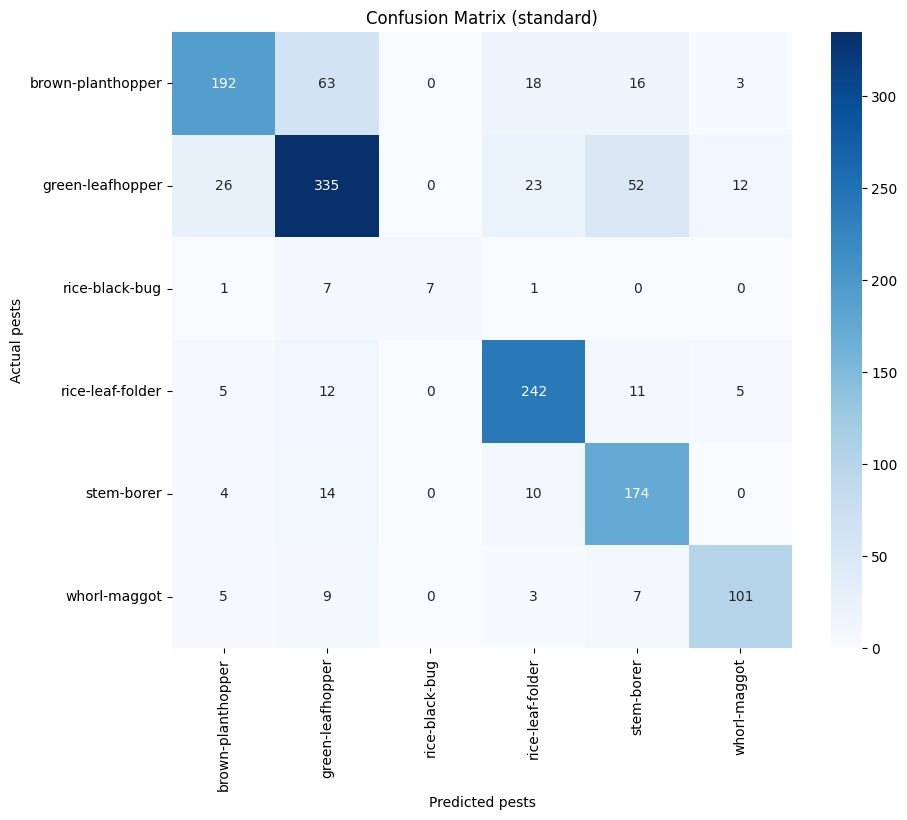


Final Stacking Ensemble Accuracy: 0.7739


In [85]:
test_dir = 'datasets/test'

resnet_model = PestClassifierResNet50(num_classes=6)
state_dict = torch.load('new_models/Resnet50/SResNet50_rice_pest_classificationV3.pt', map_location=hardware)
resnet_model.load_state_dict(state_dict)
resnet_model.to(hardware)

knn_pipeline = joblib.load('Knn_expreiment/resnet50_KNN_v2.joblib')

meta_learner = joblib.load('stacking_result/meta_learnerV2.joblib')

# Load the test dataset
test_dataset = AlbumentationsImageFolder(root=test_dir, transform=validation_pipeline)
test_image_paths = [sample[0] for sample in test_dataset.samples]
y_true = np.array([sample[1] for sample in test_dataset.samples])

# Get predictions for the test set
test_resnet_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_resnet_preds = get_resnet_predictions(resnet_model, test_resnet_loader, hardware)
test_hog_features = get_hog_features(test_image_paths)
test_knn_preds = knn_pipeline.predict_proba(test_hog_features)

X_test_meta = np.concatenate((test_resnet_preds, test_knn_preds), axis=1)

class_names = test_dataset.classes

evaluate_meta_learner(meta_learner, X_test_meta, y_true, class_names)

<h2>Deep learning stacking </h2>

Using device: cuda
Loading pre-trained ResNet-50 and EfficientNetV2-M models...

Generating predictions for the stacking ensemble...


ResNet Predictions: 100%|██████████| 296/296 [00:55<00:00,  5.30it/s]



Training the final meta-learner...
Stacking Ensemble training complete.

Meta-learner model saved as 'stacking_result/meta_learner_res_eff.joblib'

--- Evaluating the meta-learner on the val set ---


ResNet Predictions: 100%|██████████| 85/85 [00:16<00:00,  5.27it/s]



--- Final Classification Report ---
                   precision    recall  f1-score   support

brown-planthopper       0.97      0.97      0.97       581
 green-leafhopper       0.98      0.98      0.98       893
   rice-black-bug       1.00      1.00      1.00        30
 rice-leaf-folder       0.98      0.99      0.99       548
       stem-borer       0.99      0.98      0.99       404
     whorl-maggot       0.98      0.99      0.99       248

         accuracy                           0.98      2704
        macro avg       0.98      0.98      0.98      2704
     weighted avg       0.98      0.98      0.98      2704



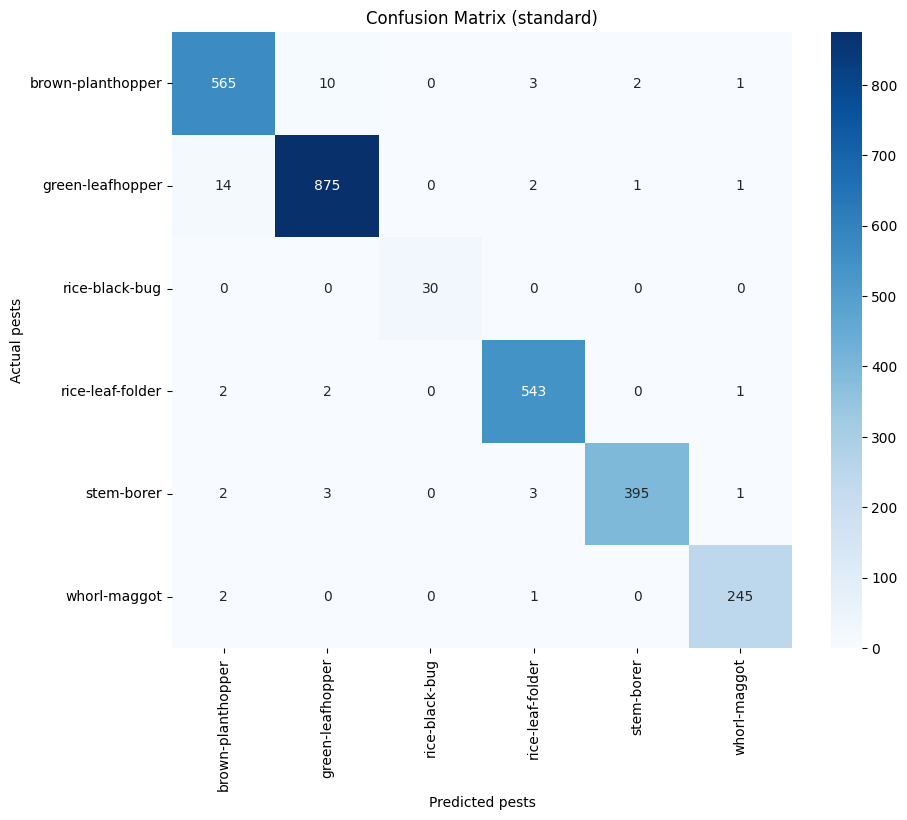


Final Stacking Ensemble Accuracy: 0.9811
Done!


In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = 'datasets/train'
val_dir = 'datasets/val'

# --- Load Data ---
full_dataset = AlbumentationsImageFolder(root=data_dir, transform=validation_pipeline)
val_dataset = AlbumentationsImageFolder(root=val_dir, transform=validation_pipeline)

num_classes = len(full_dataset.classes)
full_labels = np.array([sample[1] for sample in full_dataset.samples])

train_indices, _ = train_test_split(
    range(len(full_dataset)), test_size=0.2, random_state=42, stratify=full_labels
)

# --- Load Pre-trained Base Models ---
print("Loading pre-trained ResNet-50 and EfficientNetV2-M models...")

resnet_model = PestClassifierResNet50(num_classes=num_classes)
state_dict_res = torch.load('new_models/Resnet50/SResNet50_rice_pest_classificationV3.pt', map_location=device)
resnet_model.load_state_dict(state_dict_res)
resnet_model.to(device)

efficient_model = PestClassifierEfficientNetV2M(num_classes=num_classes)
state_dict_eff = torch.load('new_models/EfficientNetV2/SEfficientNetV2-m_rice_pest_classificationV14.pt', map_location=device)
efficient_model.load_state_dict(state_dict_eff)
efficient_model.to(device)

# --- Prepare Predictions for Stacking ---
print("\nGenerating predictions for the stacking ensemble...")

# Get ResNet predictions
train_resnet_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)
resnet_preds = get_resnet_predictions(resnet_model, train_resnet_loader, device)

# Get EfficientNet predictions
efficient_preds = get_resnet_predictions(efficient_model, train_resnet_loader, device)

# Create meta-features for training
X_meta_train = np.concatenate((resnet_preds, efficient_preds), axis=1)[train_indices]
y_meta_train = full_labels[train_indices]

# --- Train the Final Meta-Learner ---
print("\nTraining the final meta-learner...")
meta_learner = LogisticRegression(solver='lbfgs', max_iter=1000)
meta_learner.fit(X_meta_train, y_meta_train)

print("Stacking Ensemble training complete.")

# --- Save the Entire Ensemble Model ---
joblib.dump(meta_learner, 'stacking_result/meta_learner_res_eff.joblib')
print("\nMeta-learner model saved as 'stacking_result/meta_learner_res_eff.joblib'")

# --- Evaluation on Val Set ---
print("\n--- Evaluating the meta-learner on the val set ---")

# Get predictions for the val set
val_resnet_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
val_resnet_preds = get_resnet_predictions(resnet_model, val_resnet_loader, device)
val_efficient_preds = get_resnet_predictions(efficient_model, val_resnet_loader, device)

X_val_meta = np.concatenate((val_resnet_preds, val_efficient_preds), axis=1)
y_true_val = np.array([sample[1] for sample in val_dataset.samples])

# Evaluate the meta-learner
class_names = full_dataset.classes
evaluate_meta_learner(meta_learner, X_val_meta, y_true_val, class_names)

print("Done!")

<h2> Support vector </h2>